# # CarND Term1 Project 5 - Vehicle detection

In [37]:
import os

import cv2
import glob
import numpy as np
import pdb
import pickle
import random
import skimage
import sklearn
import time
import threading

# Specific imports.
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from multiprocessing import Queue
from scipy.ndimage.measurements import label
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from skimage.feature import hog

# video processing
from moviepy.editor import VideoFileClip
%matplotlib inline

In [2]:
# Plot images utility.
def plot_images(imgs, labels, rows=1, cols=3):
    """ 
    Plot images in rowXcol format.
    imgs: List of images to display.
    lables: List of lables for the images to display
    """
    display_imgs = imgs
    display_labels = labels
    fig, axis = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
    axis = axis.ravel()
    for index in range(len(display_imgs)):
        img = display_imgs[index]
        if ((not isinstance(img, tuple)) and
            (len(img.shape) == 3 and img.shape[2] == 1)):
            img = np.squeeze(img, axis=(2,))

        axis[index].imshow(img, cmap='gray')
        axis[index].set_title(display_labels[index], fontsize=20)
    plt.tight_layout()

In [3]:
# Load training images.

def get_all_files(base_path, f_type="*.jpeg"):
    "Return a list of files of given type."
    files = []
    glob_path = base_path + "/**/" + f_type
    for fname in glob.glob(glob_path, recursive=True):
        files.append(fname)
    return files

car_files = []
non_car_files = []

car_files = get_all_files("../vehicles", "*.png")
non_car_files = get_all_files("../non-vehicles", "*.png")

# Shuffle input data.
car_files = sklearn.utils.shuffle(sklearn.utils.shuffle(car_files))
non_car_files = sklearn.utils.shuffle(sklearn.utils.shuffle(non_car_files))


In [4]:
# Test and view some images.
print("Overall car files:", len(car_files))
print("Overall of non-car files:", len(non_car_files))

Overall car files: 8792
Overall of non-car files: 8968


Image shape (64, 64, 3)


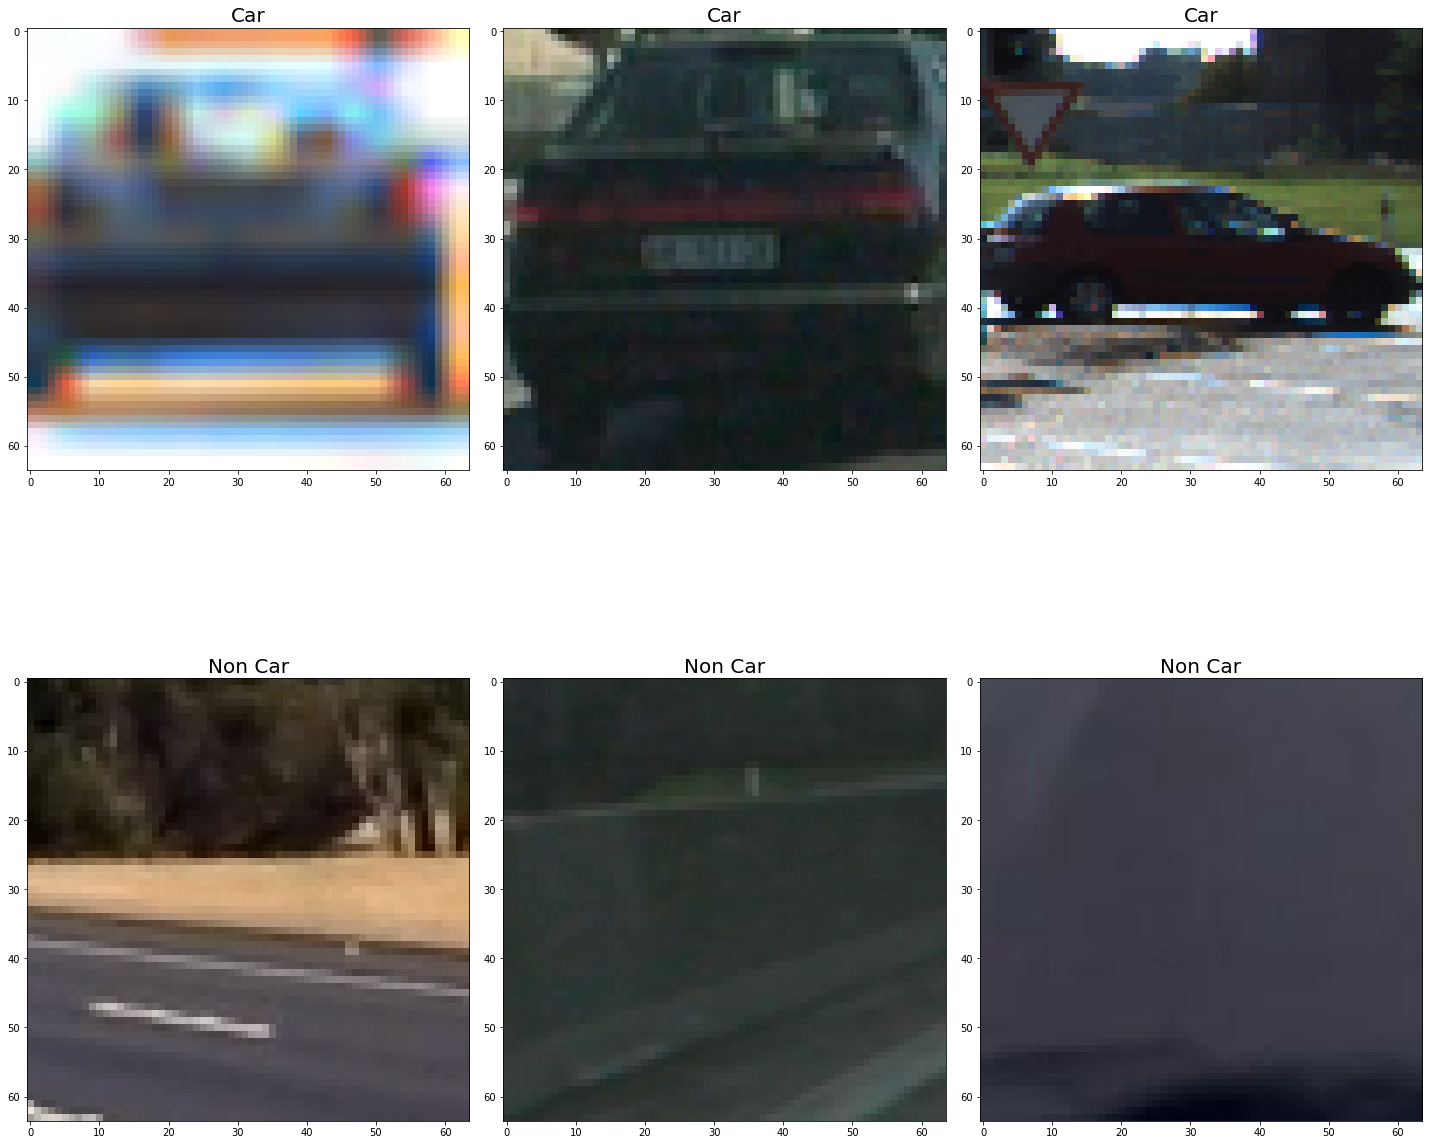

In [5]:
# Display Car and Non-car images.
display_imgs = []
display_labels = []
for i in range(3):
    img = mpimg.imread(car_files[i])
    display_imgs.append(img)
    display_labels.append("Car")
for i in range(3):
    img = mpimg.imread(non_car_files[i])
    display_imgs.append(img)
    display_labels.append("Non Car")
    
print("Image shape", img.shape)
plot_images(display_imgs, display_labels, rows=2, cols=3)

In [6]:
# Create a image parameter class to hold feature parameters.
# ATM, no methods but most of these could be changed using members.
class Feature_Params():
    """ Image feature parameter object."""
    def __init__(self):
        """ Initialize all params to default values."""
        # used for color spacing parameter; This seem effective overall.
        self.color_space = "YCrCb"
        # Final image size which is used to extract features.
        self.req_size = (32, 32)
        # HOG orient parameter.
        self.orient = 9
        # HOG pix_per_cell param
        self.pix_per_cell = (8, 8)
        # HOG cell_per_block
        self.cells_per_block = (2, 2)
        # Visualize HOG features
        self.hog_vis = False
        # Ravel before returning HOG
        self.feature_vec = True  
        # For color histograms
        self.nbins = 32
        # Range of bins; This could very well be detected. For now constant.
        self.bins_range = (0, 256)


        # Training Test data sets.
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.y_test = None
        self.X_scaler = None
        # Ref to classifier.
        self.svc = None
        
        self.heat_threshold = 2

In [7]:
def get_color_space(img, feature_params):
    """ Returns the requested color space other than RGB. """
    # Convert image to new color space (if specified)
    # Ref: https://chatbotslife.com/vehicle-detection-and-tracking-using-computer-vision-baea4df65906
    #   YcrCB
    # Along with some simple testing on images.
    assert feature_params, " Image feature object is empty."
    
    color_space = feature_params.color_space
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img) 
    return feature_image

In [8]:
# Exploring color space. 

def bin_spatial(img, feature_params):
    """ Takes an image and requested color_space,  converts
    it to the requested space and returns a 1 dimension
    feature vector.
    """
    assert feature_params, "Feature parameter is empty."
    
    size = feature_params.req_size
    # Apply to all channels, not much of difference.
    features = cv2.resize(img, size).ravel() 
    return features

In [9]:
# Get Histogram Orientation of Gradients (HOG) of image.
def get_hog_features(img, feature_params):
    """ Returns HOG features of an image.
    http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#id3
    """
    
    assert feature_params, "Feature parameter is empty."
    fp = feature_params
    if fp.hog_vis:
        features, hog_image = hog(img, orientations=fp.orient,
                            pixels_per_cell= fp.pix_per_cell,
                            cells_per_block= fp.cells_per_block, 
                            transform_sqrt=False,
                            visualise=fp.hog_vis,
                            feature_vector=fp.feature_vec)
    
        return features, hog_image
    else:
        features = hog(img, orientations=fp.orient,
                            pixels_per_cell= fp.pix_per_cell,
                            cells_per_block= fp.cells_per_block, 
                            transform_sqrt=False,
                            visualise=fp.hog_vis,
                            feature_vector=fp.feature_vec)
        return features

def get_all_hog_features(img, feature_params):
    """ Returns combined HOG features of different channels in an image."""
    
    combined = []
    for channel in range(img.shape[2]):
        n_img = img[:,:,channel]
        combined.append(get_hog_features(n_img, feature_params))
    return np.ravel(combined)

In [10]:
# Compute color histograms.
def color_histogram(img, feature_params):
    """ Returns a combined histogram of features of all color channels.
    Assumes image to be in RGB.
    """
    assert feature_params, "Feature parameter is empty."
    nbins = feature_params.nbins
    bins_range = feature_params.bins_range
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Concatenate the histograms into a single feature vector
    features = np.concatenate((channel1_hist[0], 
                            channel2_hist[0], channel3_hist[0]))
    return features

In [11]:
# Get indivijual feature maps. When parsing images in video 
# features need to be applied only to region/rectangle. HOG features
# are applied on all the image and indivijual HOG is applied  for rectangle.

def get_image_features(img, fp, is_sliding_w=False):
    """ Return combined features of input image. Image is to be
    in RGB.
    """
    
    f_img = img
    img_features = []
    
    if is_sliding_w:
        # If its a sliding window sub-image; color space and hog features
        # are done across image; prior to this call.
        spatial_features = bin_spatial(f_img, fp)
        color_hist_features = color_histogram(f_img, fp)
        # Combine features
        img_features.append(spatial_features)
        img_features.append(color_hist_features)
    else:
        # Preserve order of steps.
        # Get requested color space.
        f_img = get_color_space(img, fp)
        # Change the size of image.
        spatial_features = bin_spatial(f_img, fp)
        # Get HOG features for all channels.
        hog_features = get_all_hog_features(f_img, fp)
        # Get color histogram for all channels.
        color_hist_features = color_histogram(f_img, fp)

        img_features.append(spatial_features)
        img_features.append(color_hist_features)
        img_features.append(hog_features)
    return img_features


In [12]:
def extract_features(img_files, fp):
    """ Return combined feature vector of all training images.
    """
    features = []
    for file in img_files:
        img = mpimg.imread(file)
        file_features = np.concatenate(get_image_features(img, fp))
        features.append(file_features)
    return features

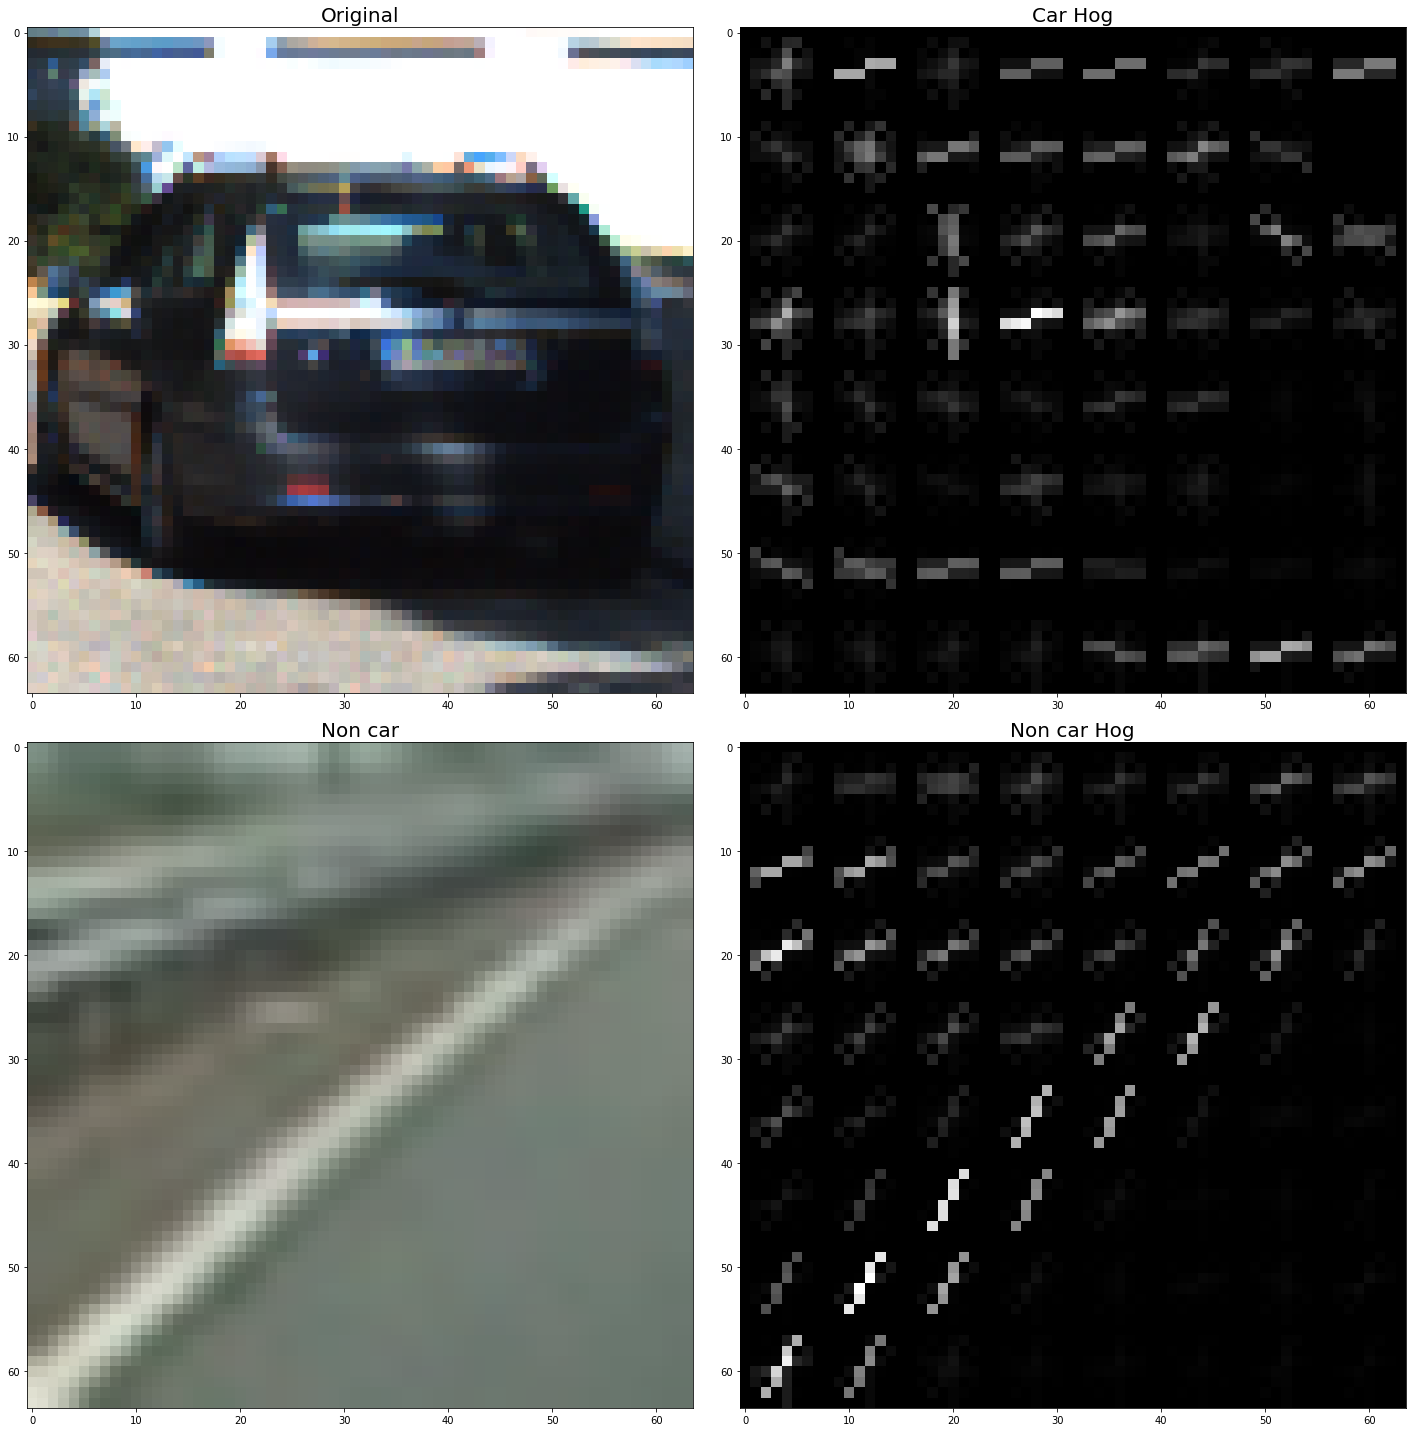

In [13]:
# Load a sample image to test various features.
car_file = "../vehicles/KITTI_extracted/13.png"
non_car_file = "../non-vehicles/GTI/image13.png"
test_file = "./test_images/test6.jpg"
test_img = mpimg.imread(test_file)
test_car = mpimg.imread(car_file)
test_non_car = mpimg.imread(non_car_file)

test_fp = Feature_Params()
test_fp.hog_vis = True
_, hog_car = get_hog_features(test_car[:,:,0], test_fp)
_, non_hog_car = get_hog_features(test_non_car[:,:,0], test_fp)
plot_images([test_car, hog_car, test_non_car, non_hog_car], 
            ["Original", "Car Hog", "Non car", "Non car Hog"],
            rows=2, cols=2)
# reset params.
test_fp.hog_vis = False

In [14]:
# Train test features.

def get_training_data(car_files, non_car_files, fp, force=False):
    """ 
    Return Training and test data sets from given a list of 
    car and non-car items. These values are also stored in feature
    parameter object.
    """
    assert fp, "Feature parameters is empty."
    original_features = None
    # This is costly unless some parameter is changed just return 
    # from previous calculations. Could be done better with
    # change in params.
    if not force:
        return fp.X_train, fp.y_train, fp.X_test, fp.y_test
    
    car_features = extract_features(car_files, fp)
    non_car_features = extract_features(non_car_files, fp)

    # Get training data
    X_train = np.vstack((car_features, non_car_features)
                   ).astype(np.float64) 
    original_features = X_train
    
    # Start Normalization.
    X_scaler = StandardScaler().fit(X_train)
    # Apply the scaler to X
    X_scaled = X_scaler.transform(X_train)

    # Define the labels vector; 1 for 'car' 0 for 'non-car'
    y = np.hstack((np.ones(len(car_features)),
               np.zeros(len(non_car_features))))

    # Now that we have X (train data) and y (labels); 
    # split few to test and possibly another shuffle.
    rand_state = np.random.randint(0, 100)
    fp.X_train, fp.X_test, fp.y_train, fp.y_test = \
            train_test_split(X_scaled, y, test_size=0.2,
                             random_state=rand_state)

    fp.X_scaler = X_scaler
    return original_features, fp.X_train, fp.y_train, fp.X_test, fp.y_test

In [15]:
# Linear Support vector machines.
# https://www.edvancer.in/logistic-regression-vs-decision-trees-vs-svm-part1/
# In this project, goal is to identify cars. Meaning everything else is non-car.
# so if there is a way to seperate cars from rest, we should be good.
# "SVM works by projecting your feature space into kernel space and making
# the classes linearly separable."
# I believe we do not need to classify complex features with-in car but general car features
# from given training set. To keep it simple, linearSVM will be applied.
# https://pdfs.semanticscholar.org/2ce0/664cfcb32461b900dd9e889cbbb2259c503e.pdf

def linear_svc(X_train, y_train, X_test, y_test):
    """ Trains input and returns SVC. 
    """

    # Kernel is linear as we intend to decide car/non-car.
    # C parameter: Tradeoff between smooth decision boundry vs better 
    # classification of training set.   
    c_param = 100.0
    svc = LinearSVC(C=c_param)
    # Calculate training time.
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print('Seconds to train SVC:', round(t2-t, 2))

    # Check the score of the SVC
    print('Test Accuracy of SVC:', round(svc.score(X_test, y_test), 4))
    
    return svc

In [39]:
# Test classifier.
fp = Feature_Params()
fp.feature_vec = True

orig_features, X_train, y_train, X_test, y_test = \
        get_training_data(car_files, non_car_files, fp, force=True)

print("Training Features:", len(X_train))
print("Test Features:", len(X_test))
    
svc = linear_svc(X_train, y_train, X_test, y_test)
fp.svc = svc

Training Features: 14208
Test Features: 3552
Seconds to train SVC: 7.0
Test Accuracy of SVC: 0.9882


(8460,)
(8460,)


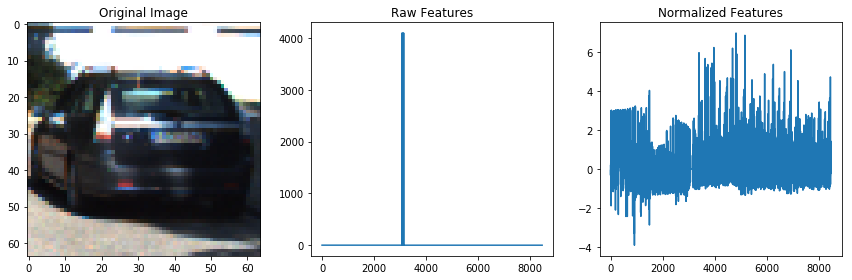

In [17]:
# Examine raw features vs normalizaed feature set of test car.
raw_features = extract_features([car_file], fp)
raw_features = np.hstack(raw_features).reshape(1, -1)
raw = raw_features.ravel()

normalized_features = fp.X_scaler.transform(raw_features).ravel()
print(raw.shape)
print(normalized_features.shape)
# Plot an example of raw and scaled features; Ref: udacity.
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(test_car)
plt.title('Original Image')
plt.subplot(132)
plt.plot(raw)
plt.title('Raw Features')
plt.subplot(133)
plt.plot(normalized_features)
plt.title('Normalized Features')
fig.tight_layout()

In [18]:
# Take 10 samples and verify prediction.
n = 10
# Random shuffle data; start from 0.
actual_predicts = fp.svc.predict(X_test[0:n])
expected_predicts = y_test[0:n]
for i in range(n):
    print("Actual: %d Expected: %d" % (actual_predicts[i],
                                       expected_predicts[i]))

Actual: 1 Expected: 1
Actual: 1 Expected: 1
Actual: 0 Expected: 0
Actual: 0 Expected: 0
Actual: 0 Expected: 0
Actual: 0 Expected: 0
Actual: 0 Expected: 0
Actual: 1 Expected: 1
Actual: 0 Expected: 0
Actual: 0 Expected: 0


In [19]:
# Using sliding window find all window regions where a vehicle is detected.
def get_vehicle_regions(img, fp, y_low_high, scale=1.5):
    """
    Returns a list of rectangle co-ordinates for all regions where a vehicle
    is detected.
    Arguments:
    img: Original image.
    x_low_high : X region of interest in image (start, end).
    y_low_high : Y region of interest in image (start, end).
    svc : Trained classifier; support vector classifier.
    """ 
    rectangles = []
    ystart, ystop = y_low_high
    # Assuming x == y.
    pix_per_cell = fp.pix_per_cell[0]
    cells_per_block = fp.cells_per_block[0]
    
    # This assumes image has scaled to 255.
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_to_search = img[ystart:ystop,:,:]
    cs_img = get_color_space(img_to_search, fp)
    if scale != 1:
        imshape = cs_img.shape
        cs_img = cv2.resize(cs_img, (np.int(imshape[1]/scale), 
                                     np.int(imshape[0]/scale)))
    ch1 = cs_img[:,:,0]
    ch2 = cs_img[:,:,1]
    ch3 = cs_img[:,:,2]

    # Define blocks and steps.
    nxblocks = (ch1.shape[1] // pix_per_cell) - cells_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cells_per_block + 1 
    nfeat_per_block = fp.orient*cells_per_block**2
    
    # 64 was the orginal sampling rate, with 2 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cells_per_block + 1
    cells_per_step = 2  
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, fp)
    hog2 = get_hog_features(ch2, fp)
    hog3 = get_hog_features(ch3, fp)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window,
                             xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            sub_img = cv2.resize(cs_img[ytop:ytop+window, 
                                        xleft:xleft+window], (window, window))
          
            # Get other features; (bin spatial & color histogram of region.)
            features = get_image_features(sub_img, fp, is_sliding_w=True) 
            features.append(hog_features)
            # Combine all.
            features = np.hstack(features).reshape(1, -1)
            # Scale features and make a prediction
            test_features = fp.X_scaler.transform(features)    
            test_prediction = fp.svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((xbox_left, ytop_draw+ystart),
                              (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return rectangles

In [20]:
def draw_boxes(img, bboxes, color=(0, 255, 0), thick=4):
    """ Add boxes to given image and return new image.
    Boxes: rectangles shape ex:((top_left, bottm_right))
    """
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return imcopy

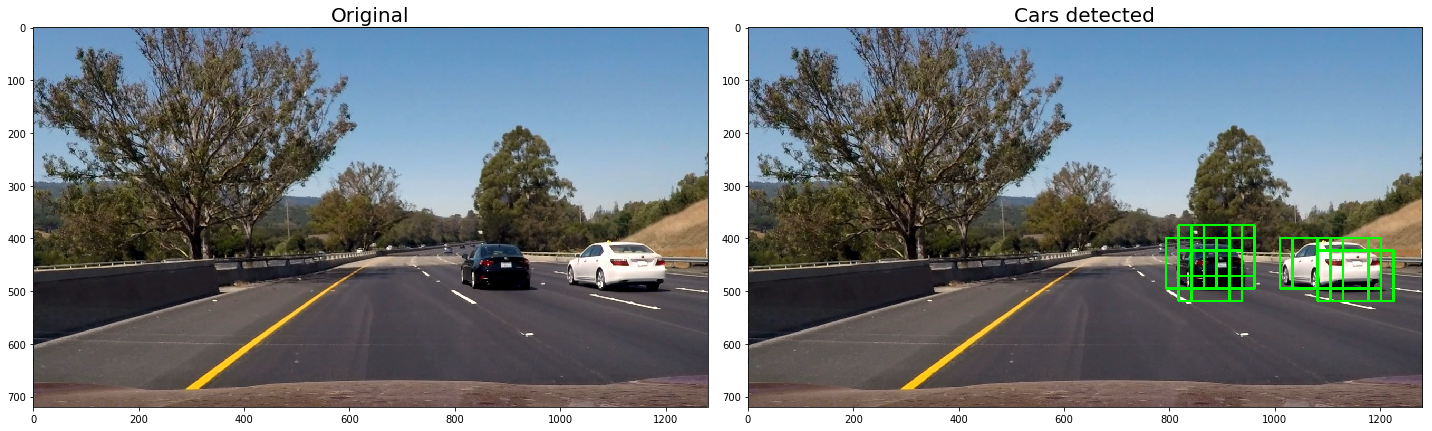

In [21]:
# Test with single region.

# This is useful for sub-sampling. No ravel before returning HOG.
fp.feature_vec = False

img = test_img 
y_low_high = (375, 656)
scale = 1.5
boxes = get_vehicle_regions(img, fp, y_low_high, scale)
detected_img = draw_boxes(img, boxes)
plot_images([img, detected_img], ["Original", "Cars detected"], rows=1, cols=2)


In [22]:
def multi_scaled_window_search(orig_img, fp, group_size=False):
    """
    Return region of boxes identified for an image.
    group_size: Groups boxes according to scales.
    """
    y_low_highs = [(340, 656), (350, 656), (375, 656), (400, 656)]
    scales = [1.0, 1.5, 2.5, 3.5]
    # List of rectangular boxes identified with points (X, Y)
    final_boxes = []
    for w_params in zip(y_low_highs, scales):
        boxes = get_vehicle_regions(orig_img, fp, w_params[0], w_params[1])
        if group_size:
            final_boxes.append(boxes)
        else:
            final_boxes.extend(boxes)
    return final_boxes
        
# Find vehicles using different scales and intrest area of
# original input image.
def draw_multiscaled_windows(orig_img, fp, overlap_boxes=True):
    """
    Returns a list of images with various sliding widows detected.
    """
    # Final list of images to return.
    result_imgs = []
    # Different colors for various sizes.
    colors = [(0, 255, 0), (0, 0, 255),(255, 0, 0), (0, 0, 0), (255, 255, 255)]
    img = np.copy(orig_img)
    group_boxes = multi_scaled_window_search(orig_img, fp, group_size=True)
    colors = colors[:len(group_boxes)]
    
    for w_param in zip(group_boxes, colors):
        detected_img = draw_boxes(img, w_param[0], color=w_param[1])
        # Overlap rectangles on previous detection.
        if overlap_boxes:
            img = detected_img
        else:
            result_imgs.append(detected_img)
            
    # add the final overlap image.
    if overlap_boxes:
        result_imgs.append(img)
            
    return result_imgs            

2


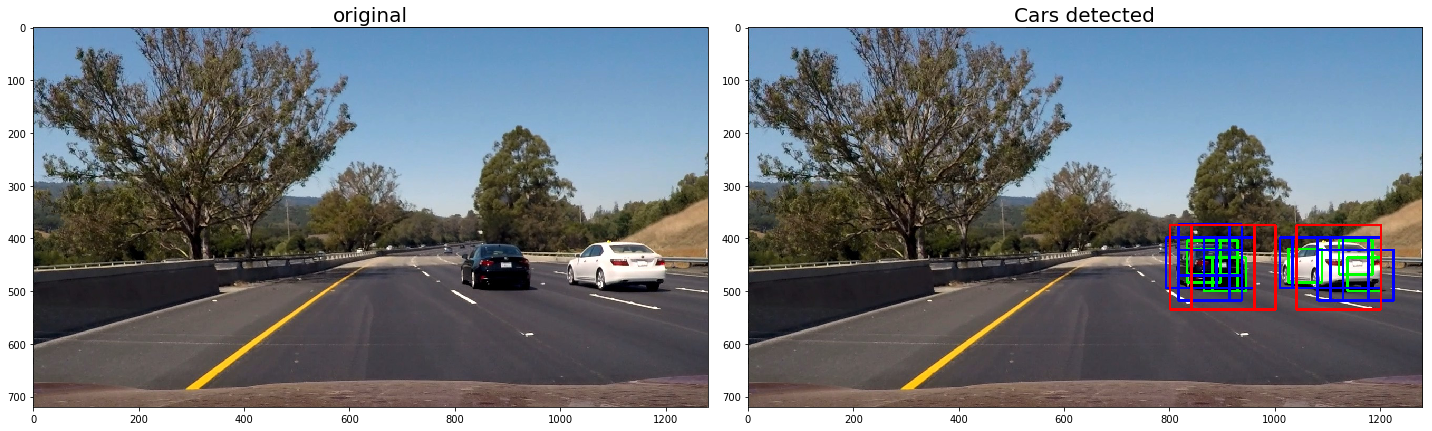

In [23]:
img = test_img
result = draw_multiscaled_windows(img, fp)
final = [img] + result
print(len(final))
plot_images(final, ["original", "Cars detected"], rows=1, cols=2)

In [24]:
# Find Heat maps and labels.
def add_heat(img, bbox_list):
    """
    Create heat map across all boxes identified in a image.
    Return list of boxes which identified as hot.
    """
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heat[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heat

def apply_threshold(heatmap, threshold=2):
    """ Given a heatmap and threshold remove areas which are 
    not considered 'hot' as intended. Remove false positives.
    Return updated heatmap.
    """
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap

def get_labeled_bboxes(img, labels):
    """ 
    Return a list of labeled boxes.
    """
    labeled_boxes = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), 
                (np.max(nonzerox), np.max(nonzeroy)))
        
        labeled_boxes.append((bbox[0], bbox[1]))
        #cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return labeled_boxes


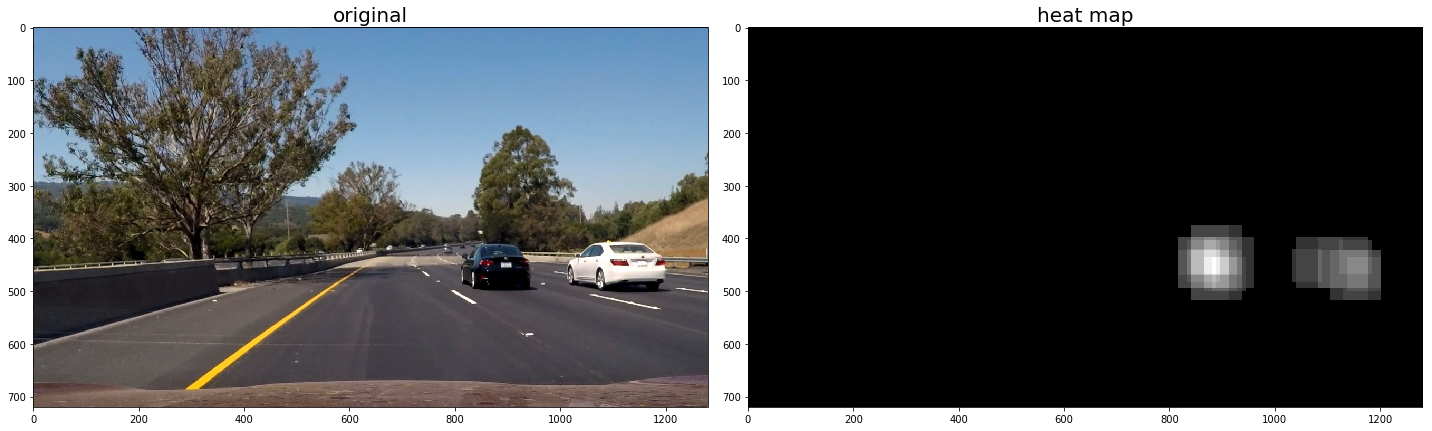

In [25]:
# Test heat map and threshold.
img = test_img
boxes = multi_scaled_window_search(img, fp)
heat_map = add_heat(img, boxes)
heat_map = apply_threshold(heat_map, threshold=2)
heat_map = np.clip(heat_map, 0, 255)
plot_images([img, heat_map], ["original", "heat map"], rows=1, cols=2)

## Alternative method - Use Previous labeled boxes for searching next frame.
Searching each frame of video with sliding window is costly. It goes over each frame
with 3 scales with 3 different window sizes. Then uses heat map and labelling to condense to labaled boxes. This is costly. We could re-use previous frames labeled boxes and extrapolate
them by a margin of ~10 pixes (left, right and forward) and then use predict we can determine
hot space without too much calculation. When prediction is below certain % we can switch back to multi scaling. This could be previously implemented but not sure. After reading through https://dam-prod.media.mit.edu/x/files/thesis/2015/savannah-ms.pdf
https://www.polygon.com/2014/6/5/5761780/frame-rate-resolution-graphics-primer-ps4-xbox-one
I felt this is a good performance ehnacement thing to do;


In [26]:
# Not working as expected; TODO. reviewer: This method is not called now.
def get_regions_from_prev(img, fp, boxes):
    """
    Returns a list of rectangle co-ordinates for all regions where a vehicle
    is detected.
    Arguments:
    img: Original image.
    x_low_high : X region of interest in image (start, end).
    y_low_high : Y region of interest in image (start, end).
    svc : Trained classifier; support vector classifier.
    """ 
    
    # This is the first region for original scaling.
    ystart, ystop = (340, 656)
    rectangles = []
    input_boxes = []
    # Assuming x == y.
    pix_per_cell = fp.pix_per_cell[0]
    cells_per_block = fp.cells_per_block[0]
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cells_per_block + 1
    
    # This assumes image has scaled to 255.
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_to_search = img[ystart:ystop,:,:]
    cs_img = get_color_space(img_to_search, fp)
    
    ch1 = cs_img[:,:,0]
    ch2 = cs_img[:,:,1]
    ch3 = cs_img[:,:,2]
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, fp)
    hog2 = get_hog_features(ch2, fp)
    hog3 = get_hog_features(ch3, fp)
    
    # Create new boxes based on old
    delta = 32
    side_delta = delta // 2
    
    for box in boxes:
        # Add left.
        top_left_x = box[0][0]+side_delta
        top_left_y = (box[0][1]-side_delta) - ystart
        bottom_right_x = box[1][0]+side_delta
        bottom_right_y = (box[1][1]-side_delta) - ystart
        input_boxes.append(((top_left_x, top_left_y), 
                            (bottom_right_x, bottom_right_y)))
        
        # Add right
        top_left_x = box[0][0]-side_delta
        top_left_y = (box[0][1]-side_delta) - ystart
        bottom_right_x = box[1][0]-side_delta
        bottom_right_y = (box[1][1]-side_delta) - ystart
        input_boxes.append(((top_left_x, top_left_y),
                            (bottom_right_x, bottom_right_y)))
        
        # Add straight
        top_left_x = box[0][0]
        top_left_y = (box[0][1]-delta) - ystart
        bottom_right_x = box[1][0]
        bottom_right_y = (box[1][1]-delta) - ystart
        input_boxes.append(((top_left_x, top_left_y),
                            (bottom_right_x, bottom_right_y)))
    
        # Add original
        top_left_x = box[0][0]
        top_left_y = box[0][1] - ystart
        bottom_right_x = box[1][0]
        bottom_right_y = box[1][1] - ystart
        input_boxes.append(((top_left_x, top_left_y),
                            (bottom_right_x, bottom_right_y)))
        
    for rect in input_boxes:
        tl_x = rect[0][0]
        tl_y = rect[0][1]
        br_x = rect[1][0]
        br_y = rect[1][1]
        
        # Get hog features of box.
        hog_feat1 = hog1[tl_y:br_y, tl_x:br_x].ravel()
        hog_feat2 = hog2[tl_y:br_y, tl_x:br_x].ravel()
        hog_feat3 = hog3[tl_y:br_y, tl_x:br_x].ravel()
        hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
        pdb.set_trace()
        sub_img = cs_img[tl_y:br_y, tl_x:br_x]
        # Get features
        features = get_image_features(sub_img, fp, is_sliding_w=True)
        
        features.append(hog_features)
        # Combine all.
        features = np.hstack(features).reshape(1, -1)
            
        # Scale features and make a prediction
        test_features = fp.X_scaler.transform(features)    
        test_prediction = fp.svc.predict(test_features)
        if test_predition == 1:
            rectangles.append(rect)
            
    # Scale back to origianl height
    ret_rectangles = []
    for box in rectangles:
        top_left_x = box[0][0]
        top_left_y = box[0][1] + ystart
        bottom_right_x = box[1][0]
        bottom_right_y = box[1][1] + ystart
        ret_rectangles.append(((top_left_x, top_left_y),
                               (bottom_right_x, bottom_right_y)))
        
    return ret_rectangles

In [27]:

# Workflow to parse the boxes identified with heat map and 
# labelling to identify final box which fits a vehicle.
fp.feature_vec = False
def find_vehicles(orig_img, fp, p_frame=None, return_boxes=False):
    """
    Returns an image with detected vehicles or labeled boxes based on
    argument return_boxes.
    fp: image feature parameters.
    p_frame : Video frame deque object of type VehicleVideoFrame
    """
    
    threshold = 2
    p_boxes = []
    p_threshold = 0
    if p_frame is not None:
        # Use last frame detected boxes to be used in current detection.
        p_boxes = p_frame.last_frame_boxes()
        # Have the new threshold to be half of previous to
        # eliminate false positives and at the same time not to
        # ignore new ones. Bug: Need to address it per car level or not?
        p_threshold = int(len(p_boxes)//2)
    
    # Get a list of boxes(represented as rectangles) where a 
    # Vehicle is detected using multi sliding window technique.
    boxes = multi_scaled_window_search(orig_img, fp)
    
    # Implements Boxes from previous frame technique. Commented out.
    #if p_frame is not None and len(p_frame) == p_frame.maxlen \
    #    and p_frame.prev_n < 2:
    #    boxes = get_regions_from_prev(orig_img, fp, p_boxes)
    #    # If number of new boxes are less than previous detected boxes, something
    #    # is a miss. Start with sliding window again.
    #    # For every 3 frames switch to Multi-scale-window search.
    #    if len(new_boxes) < len(p_boxes) or p_frame.prev_n >= 2:
    #        boxes = multi_scaled_window_search(orig_img, fp)
    #        p_frame.prev_n = 0
    #    else:
    #        p_frame.prev_n += 1
    #        # Debug
    #        prev_frames += 1
    #else:
    #   boxes = multi_scaled_window_search(orig_img, fp)
    
    if p_frame is not None:
        boxes.extend(p_boxes)
        
    # Heatmap across all boxes.
    heatmap = add_heat(orig_img, boxes)
    
    if p_frame is not None:
        threshold += p_threshold
        
    # Apply threshold to remove false positives
    heatmap_th = apply_threshold(heatmap, threshold=threshold)
    
    # Visualize the heatmap when displaying    
    heatmap_th = np.clip(heatmap_th, 0, 255)
    
    # Get labels for heat maps.
    labels = label(heatmap_th)
    
    # Map boxes to labels and resize boxes accordingly.
    labeled_boxes = get_labeled_bboxes(orig_img, labels)
    
    if p_frame is not None:
        # Add detected boxes here to be used for next frame.
        p_frame.add_frame_info(labeled_boxes)
        
    # More of a hack here. Not ideal to return 2 different types based
    # on input param.
    if return_boxes:
        return labeled_boxes
    else:
        # Draw labeled boxed on image.
        detected_img = draw_boxes(orig_img, labeled_boxes, color=(0,255,0))
        return detected_img

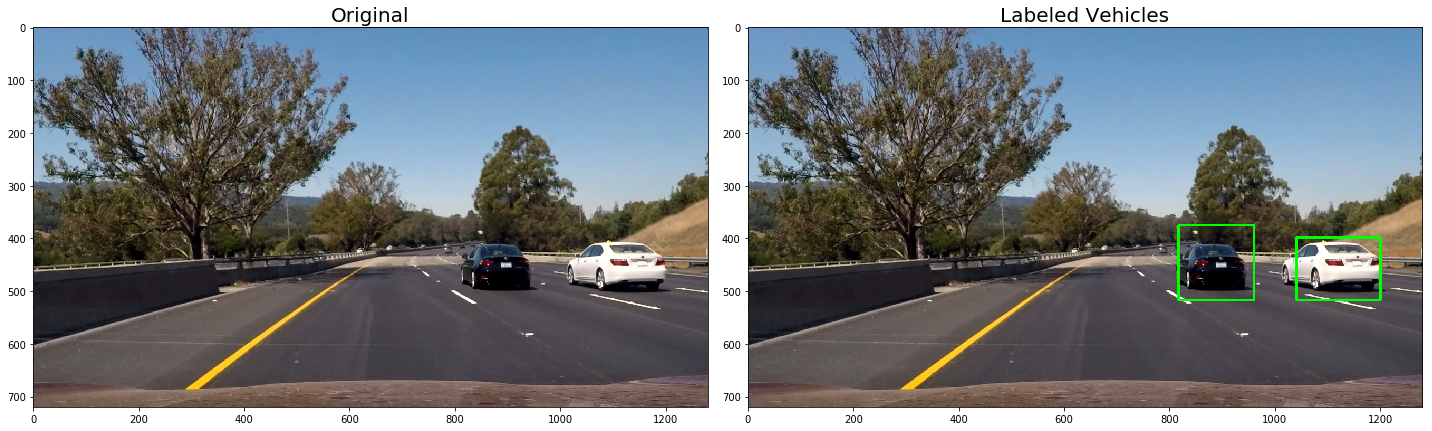

In [31]:
# Test final image processing.
img = test_img
final = find_vehicles(img, fp)
plot_images([img, final], ["Original", "Labeled Vehicles"], rows=1, cols=2)

processing image ./test_images/test1.jpg
Saving image: ./output_images/test1.jpg
processing image ./test_images/test2.jpg
Saving image: ./output_images/test2.jpg
processing image ./test_images/test3.jpg
Saving image: ./output_images/test3.jpg
processing image ./test_images/test4.jpg
Saving image: ./output_images/test4.jpg
processing image ./test_images/test5.jpg
Saving image: ./output_images/test5.jpg
processing image ./test_images/test6.jpg
Saving image: ./output_images/test6.jpg
Done


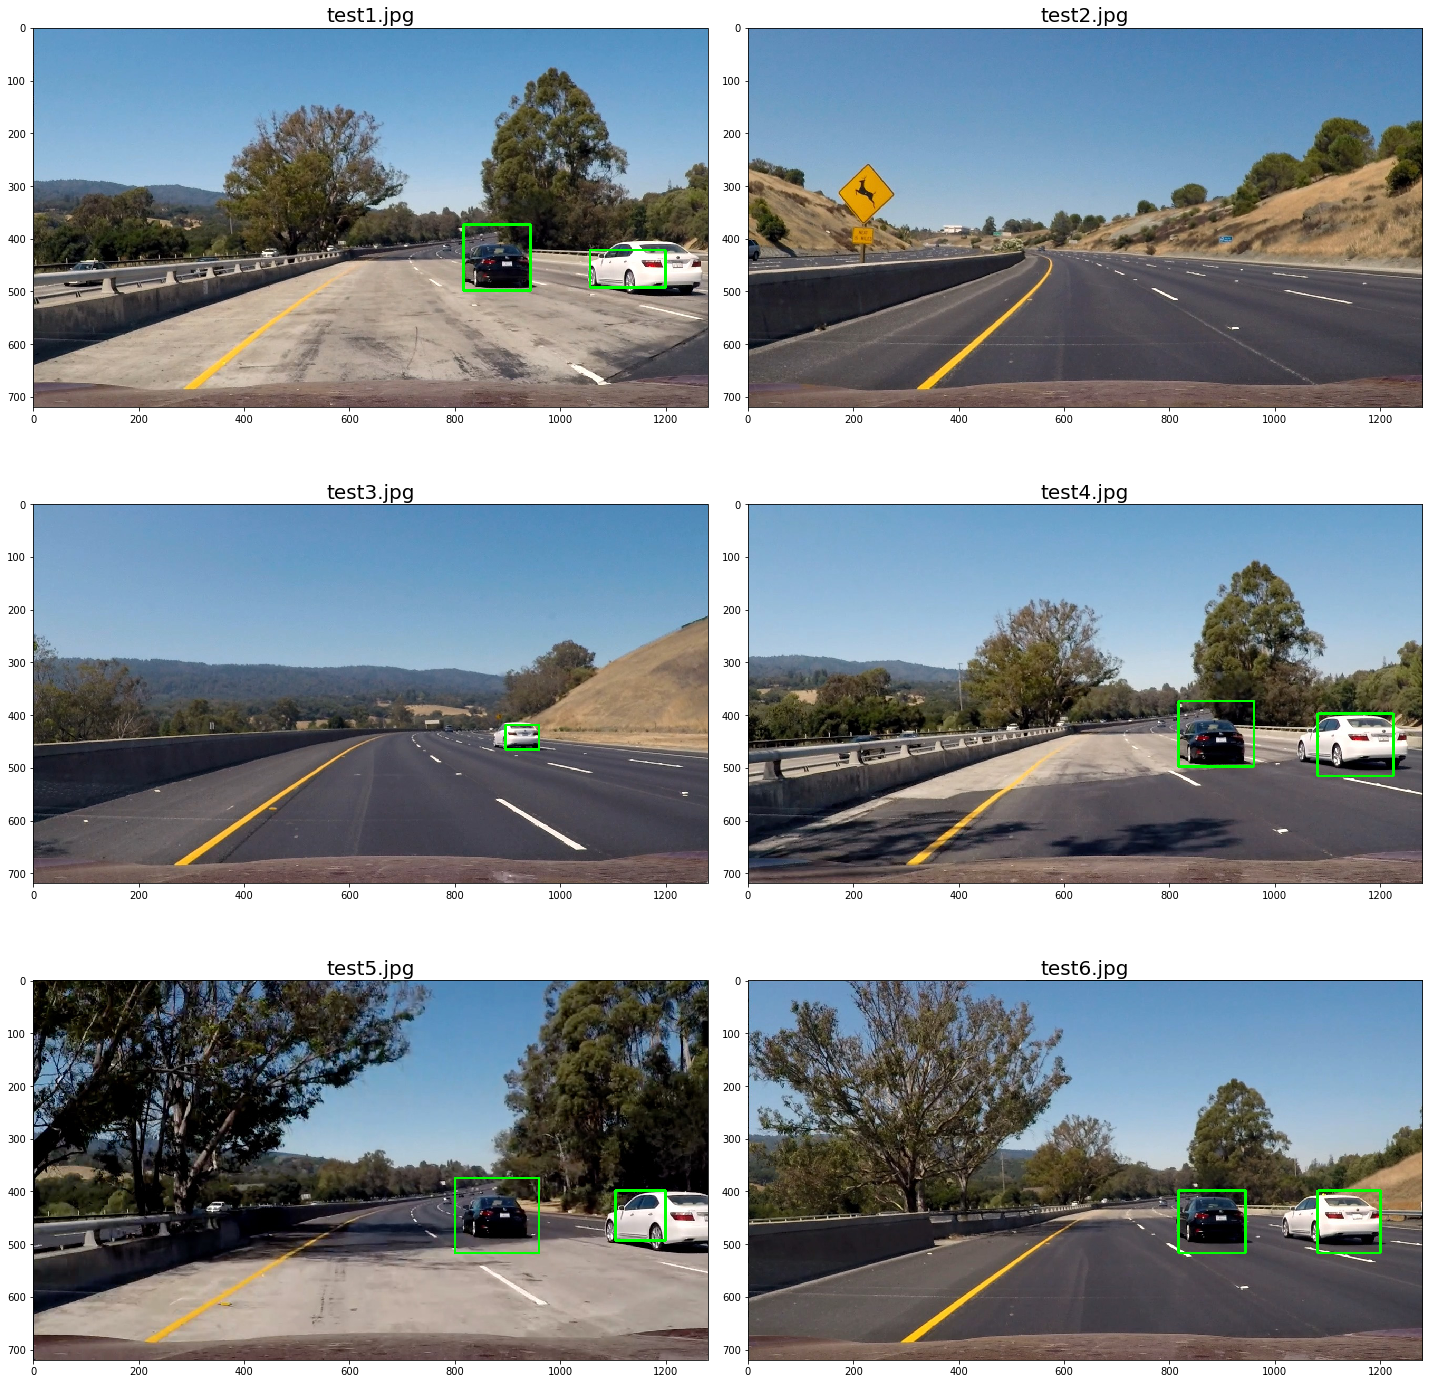

In [167]:
# Detect vehicles all test images.
test_images = glob.glob('./test_images/*.jpg')
base_output = "./output_images/"
disp_imgs = []
disp_labels = []

for i, fname in enumerate(test_images):
    print("processing image %s" % fname)
    file_name = fname.split('/')[-1]
    output = os.path.join(base_output, file_name)
    
    img = plt.imread(fname)
    detected_img = find_vehicles(img, fp)
    
    print("Saving image: %s" % output)
    plt.imsave(output, detected_img)
    
    disp_imgs.append(detected_img)
    disp_labels.append(file_name)
print("Done")

# Visualize all test images.
plot_images(disp_imgs, disp_labels, rows=3, cols=2)

In [28]:
# A class to store information related to vehicles detected
# in video frames. Mostly for processing vehicles in future
# frames using previous vehicle detection inforation.
class VehicleVideoFrame(deque):
    def __init__(self, npreviousframes=5):
        """ 
        A ring buffer like data structure to store previous frame
        rectangular boxes as single unit.
        """
        super(VehicleVideoFrame, self).__init__(maxlen=npreviousframes)
        self.prev_n = 0
        
    def add_frame_info(self, labeled_boxes):
        """ Appends the labeled boxes to end of frames. """
        self.append(labeled_boxes)
        
    def last_frame_boxes(self):
        """ Returns a list of boxes added from last frame. """
        f_len = len(self)
        if f_len == 0:
            return []
        else:
            return self[f_len-1]
    # Mostly used for using prev_frame technique.
    @property
    def prev_n(self):
        return self.__prev_n
    
    @prev_n.setter
    def prev_n(self, n):
        self.__prev_n = n

Here the the testing in done in 2 phases.
1) Process project and test video without lanes. Just vehicle detection.
2) Process project and test video and local video with lane and vehicle detection.

In [29]:
p_frame = VehicleVideoFrame(npreviousframes=5)
fp.feature_vec = False

def find_vehicles_from_frame(img):
    """ Returns detected vehicles boxes.
    """
    return find_vehicles(img, fp, p_frame=p_frame)
    
def process_vehicle_video(input, output):
    """
    Returns processed video for finding vehicles.
    input: Path to input video file
    output: Path to output video file.
    """
    # Vehicle detection variables.
    pf = VehicleVideoFrame()
    
    # Process video.
    vfc = VideoFileClip(input)
    pvi = vfc.fl_image(find_vehicles_from_frame) #subclip(0,10)
    pvi.write_videofile(output, audio=False)

In [174]:
# Process test Video with just Vehicle detection
process_vehicle_video("test_video.mp4",  "output_test_video_1.mp4")

[MoviePy] >>>> Building video output_test_video_1.mp4
[MoviePy] Writing video output_test_video_1.mp4


 97%|█████████▋| 38/39 [01:34<00:02,  2.61s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_test_video_1.mp4 



In [37]:
# Just vehicle detection.
process_vehicle_video("project_video.mp4", "out_project_video.mp4")
# Total time taken is ~47mins.

[MoviePy] >>>> Building video out_project_video.mp4
[MoviePy] Writing video out_project_video.mp4


100%|█████████▉| 1260/1261 [51:27<00:02,  2.14s/it]  


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video.mp4 



In [30]:
# Import advanced lane line project; This could be better rather
# than import *.
from advanced_lane_lines import *

In [31]:
# Test Advanced lanes is working as expected.
#create_video('./test_video.mp4', './out_advanced_lanes_test_video.mp4')

In [34]:
# Use multithreading to process lanes and vehicles and return
# processed image.

# Note: Wrapper methods are created here to handle multiprocessing of methods
# which cannot have return values but rather a queue.

p_frame = VehicleVideoFrame(npreviousframes=5)
fp.feature_vec = False
ret_queue = Queue()

def find_vehicles_adv(ret_queue, orig_img, fp, p_frame=None):
    """ Returns detected vehicles boxes.
    """
    boxes = find_vehicles(orig_img, fp, p_frame=p_frame, return_boxes=True)
    # 2 is used to identify method name. Puts the boxes in a queue instead
    # of return.
    ret_queue.put((boxes, 2))
    
def find_lanes_adv(ret_queue, img):
    """ Returns image with detected lanes with other params."""
    ret_img = process_image(img)
    # ID of this method is 1.
    ret_queue.put((ret_img, 1))
    
    
def process_video_frame(img):
    """
    Returns an image within video frame with lanes and Vehicles.
    """
    
    # Uses thread mechanism to call 2 detections and returns
    # processed image after both threads are returned.
    # For simplicity sake, Lanes method uses 1 as its ID and 
    # Vehicle detection method uses 2 as its ID.
    
    global ret_queue
    # Each gets a copy of image.
    img1 = np.copy(img) 
    img2 = np.copy(img)
        
    # Initialize threads which does their own task.
    lane_thread = threading.Thread(find_lanes_adv(ret_queue, img1))
    
    vehicle_thread = threading.Thread(find_vehicles_adv(ret_queue, 
                                        img2, fp, p_frame=p_frame))
    
    # Start threads.
    vehicle_thread.start()
    lane_thread.start()
    
    # Wait until both are done.
    vehicle_thread.join()
    lane_thread.join()
    
    # Process output from both detections.
    lane_img = None
    boxes = []
    
    while not ret_queue.empty():
        value = ret_queue.get()
        # Lane.
        if value[1] == 1:
            lane_img = value[0]
        # Vehicles
        else:
            boxes = value[0]
            
    # Return original image if either of them is empty; something is wrong.
    if (not lane_img.any()): # or (not boxes):
        return img
    else:
        # Draw boxes on detected lanes.
        processed_img = draw_boxes(lane_img, boxes, color=(0,255,0))
        return processed_img
    
def process_lane_vehicle_video(input, output):
    """
    Returns processed video for finding lanes and vehicles.
    input: Path to input video file
    output: Path to output video file.
    """
    
    # Lane Finding global variables.
    global inter_fail_cnt
    inter_fail_cnt = 0
    global inter_diff
    inter_diff = []
    # Other globals.
    global l_line
    l_line = LaneLine()
    global r_line
    r_line = LaneLine()
    
    # Vehicle detection variables.
    pf = VehicleVideoFrame()
    
    # Process video.
    vfc = VideoFileClip(input)
    pvi = vfc.fl_image(process_video_frame) #subclip(0,10)
    pvi.write_videofile(output, audio=False)


In [36]:
# Test on test_video for finding vehicle and lane lines.
process_lane_vehicle_video("test_video.mp4",  "output_lane_vehicle_test_video_1.mp4")

In [67]:
# Test with project video.
process_lane_vehicle_video("project_video.mp4",  "output_lane_vehicle_project_video.mp4")

[MoviePy] >>>> Building video output_lane_vehicle_project_video.mp4
[MoviePy] Writing video output_lane_vehicle_project_video.mp4



100%|█████████▉| 1260/1261 [1:06:26<00:03,  3.15s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_lane_vehicle_project_video.mp4 



In [ ]:
# Refs

https://docs.python.org/2/library/collections.html#collections.deque
http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html#id3
http://scikit-image.org/docs/dev/auto_examples/
http://udacity.com (Chapeters 35-38) from Vehicle detection chapter [code].
https://groups.google.com/forum/#!topic/pythonvision/AVrnueiKKYI
http://stanford.edu/~eadeli/publications/ISVC2007.pdf
https://chatbotslife.com/vehicle-detection-and-tracking-using-computer-vision-baea4df65906
https://pdfs.semanticscholar.org/2ce0/664cfcb32461b900dd9e889cbbb2259c503e.pdf
http://excel.fit.vutbr.cz/submissions/2016/004/4.pdf // Detecting vehicles using Gaussian Mixture.